In [1]:
# imports 
import numpy as np
from math import sqrt 
from pprint import pprint
from numpy import array
from scipy.io import arff
import pandas as pd
from time import time

In [2]:
# load data

df=pd.read_csv('Cardiotocography_02_v10.csv')  

del df['id']
del df['Unnamed: 0']
df['outlier'] = df.outlier.apply(lambda label: 1 if label == "'yes'" else 0)

df.head()

LB   AC   FM   UC  ASTV  MSTV  ALTV  MLTV   DL   DS   ...       Min  \
0  146.0  0.0  0.0  5.0  65.0   0.4  33.0   7.4  0.0  0.0   ...     134.0   
1  128.0  0.0  0.0  2.0  86.0   0.3  79.0   2.9  0.0  0.0   ...     114.0   
2  149.0  0.0  0.0  5.0  61.0   0.4  34.0   5.6  0.0  0.0   ...     148.0   
3  122.0  0.0  0.0  0.0  83.0   0.5   6.0  15.6  0.0  0.0   ...      62.0   
4  134.0  0.0  4.0  0.0  79.0   0.2  42.0   5.5  0.0  0.0   ...     128.0   

     Max  Nmax  Nzeros   Mode   Mean  Median  Variance  Tendency  outlier  
0  164.0   1.0     0.0  150.0  149.0   151.0       1.0       0.0        1  
1  130.0   0.0     0.0  128.0  126.0   129.0       0.0       1.0        1  
2  160.0   1.0     0.0  154.0  153.0   155.0       0.0       0.0        1  
3  130.0   0.0     0.0  122.0  122.0   123.0       3.0       1.0        1  
4  145.0   2.0     0.0  135.0  135.0   136.0       1.0       0.0        1  

[5 rows x 22 columns]

In [3]:
df.shape

(1688, 22)

In [4]:
# data to values
df = df.values

In [5]:
# Extratrees Deep
import argparse
import sys
import pickle
from sklearn.metrics import accuracy_score
sys.path.insert(0, "lib")
from gcforest.gcforest import GCForest
from gcforest.utils.config_utils import load_json
config = load_json("./examples/Cardiotocography.json")
gc = GCForest(config)

In [6]:
# train test 
from sklearn.cross_validation import train_test_split
y = df[:,21]
X = df[:,0:21]

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
# number of class
len(np.unique(y_train))

2

In [8]:
         # X_enc is the concatenated predict_proba result of DeepExtraTrees

X_train_enc, X_test_enc = gc.fit_transform(X_train, y_train, X_test=X_test, y_test=y_test)
   

[ 2018-07-27 20:34:20,614][cascade_classifier.fit_transform] X_groups_train.shape=[(1130, 21)],y_train.shape=(1130,),X_groups_test.shape=[(558, 21)],y_test.shape=(558,)
[ 2018-07-27 20:34:20,616][cascade_classifier.fit_transform] group_dims=[21]
[ 2018-07-27 20:34:20,617][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 20:34:20,618][cascade_classifier.fit_transform] group_ends=[21]
[ 2018-07-27 20:34:20,619][cascade_classifier.fit_transform] X_train.shape=(1130, 21),X_test.shape=(558, 21)
[ 2018-07-27 20:34:20,621][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(1130, 21), X_cur_test.shape=(558, 21)
[ 2018-07-27 20:34:21,141][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=97.37%
[ 2018-07-27 20:34:21,730][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=97.37%
[ 2018-07-27 20:34:22,520][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_

In [9]:
# predict
y_pred = gc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy of DeepExtraTrees = {:.6f} %".format(acc * 100))

[ 2018-07-27 20:34:26,986][cascade_classifier.transform] X_groups_test.shape=[(558, 21)]
[ 2018-07-27 20:34:26,988][cascade_classifier.transform] group_dims=[21]
[ 2018-07-27 20:34:26,989][cascade_classifier.transform] X_test.shape=(558, 21)
[ 2018-07-27 20:34:26,990][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(558, 21)


Test Accuracy of DeepExtraTrees = 98.566308 %


In [10]:
# Matrix de confusion
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

[[549   2]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.33      0.14      0.20         7

avg / total       0.98      0.99      0.98       558



In [11]:
# Make data + estimators
X_test_enc = gc.transform(X_test)
X_train_enc = X_train_enc.reshape((X_train_enc.shape[0], -1))
X_test_enc = X_test_enc.reshape((X_test_enc.shape[0], -1))
X_train_origin = X_train.reshape((X_train.shape[0], -1))
X_test_origin = X_test.reshape((X_test.shape[0], -1))
X_train_enc = np.hstack((X_train_origin, X_train_enc))
X_test_enc = np.hstack((X_test_origin, X_test_enc))

[ 2018-07-27 20:34:28,393][cascade_classifier.transform] X_groups_test.shape=[(558, 21)]
[ 2018-07-27 20:34:28,394][cascade_classifier.transform] group_dims=[21]
[ 2018-07-27 20:34:28,395][cascade_classifier.transform] X_test.shape=(558, 21)
[ 2018-07-27 20:34:28,396][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(558, 21)


In [12]:
# New data
X_train=X_train_enc
X_test=X_test_enc 
X_train_enc, X_test_enc = gc.fit_transform(X_train, y_train, X_test=X_test, y_test=y_test)

[ 2018-07-27 20:34:29,441][cascade_classifier.fit_transform] X_groups_train.shape=[(1130, 23)],y_train.shape=(1130,),X_groups_test.shape=[(558, 23)],y_test.shape=(558,)
[ 2018-07-27 20:34:29,442][cascade_classifier.fit_transform] group_dims=[23]
[ 2018-07-27 20:34:29,443][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 20:34:29,445][cascade_classifier.fit_transform] group_ends=[23]
[ 2018-07-27 20:34:29,446][cascade_classifier.fit_transform] X_train.shape=(1130, 23),X_test.shape=(558, 23)
[ 2018-07-27 20:34:29,447][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(1130, 23), X_cur_test.shape=(558, 23)
[ 2018-07-27 20:34:29,940][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=98.25%
[ 2018-07-27 20:34:30,530][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=97.37%
[ 2018-07-27 20:34:31,124][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_

In [13]:
# predict  data + Es
y_pred = gc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy of DeepExtraTrees = {:.6f} %".format(acc * 100))

[ 2018-07-27 20:34:35,656][cascade_classifier.transform] X_groups_test.shape=[(558, 23)]
[ 2018-07-27 20:34:35,658][cascade_classifier.transform] group_dims=[23]
[ 2018-07-27 20:34:35,659][cascade_classifier.transform] X_test.shape=(558, 23)
[ 2018-07-27 20:34:35,660][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(558, 23)


Test Accuracy of DeepExtraTrees = 99.103943 %


In [14]:
 # Matrix de confusion
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

[[550   1]
 [  4   3]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00       551
        1.0       0.75      0.43      0.55         7

avg / total       0.99      0.99      0.99       558



In [15]:
def update(X_train,X_test):
    # update Estimators
    M = np.delete(X_train, (-1), axis=1)
    X_train= np.delete(M, (-1), axis=1)
    M = np.delete(X_test, (-1), axis=1)
    X_test = np.delete(M, (-1), axis=1)
    return X_train,X_test

def newdata(X_test_enc, X_train_enc):
    # Make Data + Estimators
    X_train_origin = X_train.reshape((X_train.shape[0], -1))
    X_test_origin = X_test.reshape((X_test.shape[0], -1))
    X_train_enc = np.hstack((X_train_origin, X_train_enc))
    X_test_enc = np.hstack((X_test_origin, X_test_enc))
    return X_test_enc, X_train_enc

Accuracy = []
def affiche():
    # predict
    y_pred = gc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Test Accuracy of DeepExtratTrees = {:.6f} %".format(acc * 100),"Layer :",i)
    Accuracy.append(round(acc*100 , 2))
    # Matrix de confusion
    from sklearn.metrics import classification_report, confusion_matrix
    print(confusion_matrix(y_test,y_pred))
    print('\n')
    print(classification_report(y_test,y_pred))
    
# Deep
t = []
for i in range (20):
    t0 = time()
    X_train,X_test=update(X_train,X_test)
    X_test_enc, X_train_enc=newdata(X_test_enc, X_train_enc)

    X_train=X_train_enc
    X_test=X_test_enc 
    X_train_enc, X_test_enc = gc.fit_transform(X_train, y_train, X_test=X_test, y_test=y_test)
    tt = time() - t0
    affiche() 
    t.append(round(tt,2))
    print (" Time ",format(round(tt,3))," seconds")


[ 2018-07-27 20:34:37,558][cascade_classifier.fit_transform] X_groups_train.shape=[(1130, 23)],y_train.shape=(1130,),X_groups_test.shape=[(558, 23)],y_test.shape=(558,)
[ 2018-07-27 20:34:37,560][cascade_classifier.fit_transform] group_dims=[23]
[ 2018-07-27 20:34:37,561][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-27 20:34:37,562][cascade_classifier.fit_transform] group_ends=[23]
[ 2018-07-27 20:34:37,563][cascade_classifier.fit_transform] X_train.shape=(1130, 23),X_test.shape=(558, 23)
[ 2018-07-27 20:34:37,564][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(1130, 23), X_cur_test.shape=(558, 23)
[ 2018-07-27 20:34:38,059][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=98.25%
[ 2018-07-27 20:34:38,655][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=97.37%
[ 2018-07-27 20:34:39,253][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_

('Test Accuracy of DeepExtratTrees = 99.103943 %', 'Layer :', 0)
[[550   1]
 [  4   3]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00       551
        1.0       0.75      0.43      0.55         7

avg / total       0.99      0.99      0.99       558

(' Time ', '6.923', ' seconds')


[ 2018-07-27 20:34:46,012][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=98.25%
[ 2018-07-27 20:34:46,651][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=97.37%
[ 2018-07-27 20:34:47,295][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=97.37%
[ 2018-07-27 20:34:47,887][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=97.37%
[ 2018-07-27 20:34:48,481][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=99.12%
[ 2018-07-27 20:34:49,218][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=97.35%
[ 2018-07-27 20:34:49,865][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:34:50,461][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=98.21%


('Test Accuracy of DeepExtratTrees = 98.745520 %', 'Layer :', 1)
[[550   1]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.50      0.14      0.22         7

avg / total       0.98      0.99      0.98       558

(' Time ', '6.287', ' seconds')


[ 2018-07-27 20:34:53,384][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=98.25%
[ 2018-07-27 20:34:53,983][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=96.49%
[ 2018-07-27 20:34:54,590][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=98.25%
[ 2018-07-27 20:34:55,188][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=97.37%
[ 2018-07-27 20:34:55,916][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=99.12%
[ 2018-07-27 20:34:56,794][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=98.23%
[ 2018-07-27 20:34:57,714][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:34:58,713][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=99.11%


('Test Accuracy of DeepExtratTrees = 98.745520 %', 'Layer :', 2)
[[550   1]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.50      0.14      0.22         7

avg / total       0.98      0.99      0.98       558

(' Time ', '7.97', ' seconds')


[ 2018-07-27 20:35:03,808][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=98.25%
[ 2018-07-27 20:35:04,523][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=96.49%
[ 2018-07-27 20:35:05,118][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=98.25%
[ 2018-07-27 20:35:05,852][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=97.37%
[ 2018-07-27 20:35:06,488][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=99.12%
[ 2018-07-27 20:35:07,076][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=98.23%
[ 2018-07-27 20:35:07,679][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:35:08,271][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=99.11%


('Test Accuracy of DeepExtratTrees = 98.745520 %', 'Layer :', 3)
[[550   1]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.50      0.14      0.22         7

avg / total       0.98      0.99      0.98       558

(' Time ', '6.374', ' seconds')


[ 2018-07-27 20:35:11,116][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=98.25%
[ 2018-07-27 20:35:11,707][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=96.49%
[ 2018-07-27 20:35:12,315][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=98.25%
[ 2018-07-27 20:35:12,910][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=97.37%
[ 2018-07-27 20:35:13,501][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=99.12%
[ 2018-07-27 20:35:14,092][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=98.23%
[ 2018-07-27 20:35:14,736][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:35:15,331][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=98.21%


('Test Accuracy of DeepExtratTrees = 98.745520 %', 'Layer :', 4)
[[550   1]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.50      0.14      0.22         7

avg / total       0.98      0.99      0.98       558

(' Time ', '6.171', ' seconds')


[ 2018-07-27 20:35:18,960][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=98.25%
[ 2018-07-27 20:35:19,980][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=96.49%
[ 2018-07-27 20:35:20,876][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=98.25%
[ 2018-07-27 20:35:21,719][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=97.37%
[ 2018-07-27 20:35:22,309][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=99.12%
[ 2018-07-27 20:35:22,899][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=98.23%
[ 2018-07-27 20:35:23,496][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:35:24,094][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=99.11%


('Test Accuracy of DeepExtratTrees = 98.745520 %', 'Layer :', 5)
[[550   1]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.50      0.14      0.22         7

avg / total       0.98      0.99      0.98       558

(' Time ', '7.131', ' seconds')


[ 2018-07-27 20:35:27,126][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=98.25%
[ 2018-07-27 20:35:27,714][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=96.49%
[ 2018-07-27 20:35:28,322][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=98.25%
[ 2018-07-27 20:35:28,910][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=97.37%
[ 2018-07-27 20:35:29,502][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=99.12%
[ 2018-07-27 20:35:30,090][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=97.35%
[ 2018-07-27 20:35:30,803][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:35:31,397][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=99.11%


('Test Accuracy of DeepExtratTrees = 98.745520 %', 'Layer :', 6)
[[550   1]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.50      0.14      0.22         7

avg / total       0.98      0.99      0.98       558

(' Time ', '6.058', ' seconds')


[ 2018-07-27 20:35:34,227][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=98.25%
[ 2018-07-27 20:35:34,823][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=94.74%
[ 2018-07-27 20:35:35,413][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=98.25%
[ 2018-07-27 20:35:36,094][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=97.37%
[ 2018-07-27 20:35:36,950][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=99.12%
[ 2018-07-27 20:35:37,881][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=97.35%
[ 2018-07-27 20:35:38,740][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:35:39,701][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=99.11%


('Test Accuracy of DeepExtratTrees = 98.745520 %', 'Layer :', 7)
[[550   1]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.50      0.14      0.22         7

avg / total       0.98      0.99      0.98       558

(' Time ', '7.927', ' seconds')


[ 2018-07-27 20:35:44,626][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=98.25%
[ 2018-07-27 20:35:45,340][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=93.86%
[ 2018-07-27 20:35:45,928][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=98.25%
[ 2018-07-27 20:35:46,570][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=97.37%
[ 2018-07-27 20:35:47,216][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=99.12%
[ 2018-07-27 20:35:47,806][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=97.35%
[ 2018-07-27 20:35:48,398][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:35:49,146][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=97.32%


('Test Accuracy of DeepExtratTrees = 98.745520 %', 'Layer :', 8)
[[550   1]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.50      0.14      0.22         7

avg / total       0.98      0.99      0.98       558

(' Time ', '6.644', ' seconds')


[ 2018-07-27 20:35:52,116][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=97.37%
[ 2018-07-27 20:35:52,716][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=93.86%
[ 2018-07-27 20:35:53,353][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=98.25%
[ 2018-07-27 20:35:54,002][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=98.25%
[ 2018-07-27 20:35:54,594][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=99.12%
[ 2018-07-27 20:35:55,190][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=96.46%
[ 2018-07-27 20:35:56,210][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:35:57,139][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=98.21%


('Test Accuracy of DeepExtratTrees = 98.745520 %', 'Layer :', 9)
[[550   1]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.50      0.14      0.22         7

avg / total       0.98      0.99      0.98       558

(' Time ', '7.711', ' seconds')


[ 2018-07-27 20:36:01,048][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=97.37%
[ 2018-07-27 20:36:01,641][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=93.86%
[ 2018-07-27 20:36:02,229][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=98.25%
[ 2018-07-27 20:36:02,867][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=98.25%
[ 2018-07-27 20:36:03,461][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=99.12%
[ 2018-07-27 20:36:04,050][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=96.46%
[ 2018-07-27 20:36:04,641][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:36:05,230][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=98.21%


('Test Accuracy of DeepExtratTrees = 98.745520 %', 'Layer :', 10)
[[550   1]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.50      0.14      0.22         7

avg / total       0.98      0.99      0.98       558

(' Time ', '6.116', ' seconds')


[ 2018-07-27 20:36:08,173][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=98.25%
[ 2018-07-27 20:36:08,887][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=93.86%
[ 2018-07-27 20:36:09,476][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=98.25%
[ 2018-07-27 20:36:10,162][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=98.25%
[ 2018-07-27 20:36:10,754][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=99.12%
[ 2018-07-27 20:36:11,350][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=98.23%
[ 2018-07-27 20:36:11,944][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:36:12,699][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=98.21%


('Test Accuracy of DeepExtratTrees = 99.103943 %', 'Layer :', 11)
[[551   0]
 [  5   2]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00       551
        1.0       1.00      0.29      0.44         7

avg / total       0.99      0.99      0.99       558

(' Time ', '6.44', ' seconds')


[ 2018-07-27 20:36:17,229][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=97.37%
[ 2018-07-27 20:36:17,957][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=93.86%
[ 2018-07-27 20:36:18,555][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=98.25%
[ 2018-07-27 20:36:19,147][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=98.25%
[ 2018-07-27 20:36:19,744][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=98.23%
[ 2018-07-27 20:36:20,342][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=97.35%
[ 2018-07-27 20:36:20,941][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:36:21,637][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=98.21%


('Test Accuracy of DeepExtratTrees = 98.745520 %', 'Layer :', 12)
[[550   1]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.50      0.14      0.22         7

avg / total       0.98      0.99      0.98       558

(' Time ', '6.58', ' seconds')


[ 2018-07-27 20:36:24,578][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=97.37%
[ 2018-07-27 20:36:25,166][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=93.86%
[ 2018-07-27 20:36:25,763][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=98.25%
[ 2018-07-27 20:36:26,358][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=98.25%
[ 2018-07-27 20:36:26,966][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=99.12%
[ 2018-07-27 20:36:27,563][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=98.23%
[ 2018-07-27 20:36:28,207][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:36:28,923][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=98.21%


('Test Accuracy of DeepExtratTrees = 98.924731 %', 'Layer :', 13)
[[551   0]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       1.00      0.14      0.25         7

avg / total       0.99      0.99      0.99       558

(' Time ', '6.145', ' seconds')


[ 2018-07-27 20:36:31,914][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=97.37%
[ 2018-07-27 20:36:32,508][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=93.86%
[ 2018-07-27 20:36:33,366][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=98.25%
[ 2018-07-27 20:36:34,278][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=98.25%
[ 2018-07-27 20:36:35,304][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=97.35%
[ 2018-07-27 20:36:36,175][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=97.35%
[ 2018-07-27 20:36:36,893][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:36:37,491][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=98.21%


('Test Accuracy of DeepExtratTrees = 98.745520 %', 'Layer :', 14)
[[550   1]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.50      0.14      0.22         7

avg / total       0.98      0.99      0.98       558

(' Time ', '7.425', ' seconds')


[ 2018-07-27 20:36:40,363][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=97.37%
[ 2018-07-27 20:36:40,980][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=93.86%
[ 2018-07-27 20:36:41,627][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=98.25%
[ 2018-07-27 20:36:42,259][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=98.25%
[ 2018-07-27 20:36:42,895][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=99.12%
[ 2018-07-27 20:36:43,484][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=98.23%
[ 2018-07-27 20:36:44,080][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:36:44,726][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=98.21%


('Test Accuracy of DeepExtratTrees = 98.745520 %', 'Layer :', 15)
[[550   1]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.50      0.14      0.22         7

avg / total       0.98      0.99      0.98       558

(' Time ', '6.312', ' seconds')


[ 2018-07-27 20:36:47,724][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=97.37%
[ 2018-07-27 20:36:48,365][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=93.86%
[ 2018-07-27 20:36:49,011][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=98.25%
[ 2018-07-27 20:36:49,655][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=98.25%
[ 2018-07-27 20:36:50,248][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=99.12%
[ 2018-07-27 20:36:50,965][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=98.23%
[ 2018-07-27 20:36:51,770][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:36:52,672][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=99.11%


('Test Accuracy of DeepExtratTrees = 98.745520 %', 'Layer :', 16)
[[550   1]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.50      0.14      0.22         7

avg / total       0.98      0.99      0.98       558

(' Time ', '7.497', ' seconds')


[ 2018-07-27 20:36:56,265][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=97.37%
[ 2018-07-27 20:36:56,856][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=93.86%
[ 2018-07-27 20:36:57,453][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=98.25%
[ 2018-07-27 20:36:58,045][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=98.25%
[ 2018-07-27 20:36:58,687][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=99.12%
[ 2018-07-27 20:36:59,277][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=98.23%
[ 2018-07-27 20:36:59,912][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:37:00,701][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=98.21%


('Test Accuracy of DeepExtratTrees = 98.745520 %', 'Layer :', 17)
[[550   1]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.50      0.14      0.22         7

avg / total       0.98      0.99      0.98       558

(' Time ', '6.417', ' seconds')


[ 2018-07-27 20:37:04,002][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=98.25%
[ 2018-07-27 20:37:04,637][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=93.86%
[ 2018-07-27 20:37:05,383][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=98.25%
[ 2018-07-27 20:37:06,354][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=98.25%
[ 2018-07-27 20:37:06,950][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=99.12%
[ 2018-07-27 20:37:07,654][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=97.35%
[ 2018-07-27 20:37:08,627][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:37:09,480][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=98.21%


('Test Accuracy of DeepExtratTrees = 98.566308 %', 'Layer :', 18)
[[549   2]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.33      0.14      0.20         7

avg / total       0.98      0.99      0.98       558

(' Time ', '8.116', ' seconds')


[ 2018-07-27 20:37:14,619][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=97.37%
[ 2018-07-27 20:37:15,653][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=93.86%
[ 2018-07-27 20:37:16,366][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=97.37%
[ 2018-07-27 20:37:17,223][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=98.25%
[ 2018-07-27 20:37:17,937][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_4.predict)=99.12%
[ 2018-07-27 20:37:18,696][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_5.predict)=97.35%
[ 2018-07-27 20:37:19,335][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_6.predict)=98.21%
[ 2018-07-27 20:37:19,977][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_7.predict)=98.21%


('Test Accuracy of DeepExtratTrees = 98.566308 %', 'Layer :', 19)
[[549   2]
 [  6   1]]


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       551
        1.0       0.33      0.14      0.20         7

avg / total       0.98      0.99      0.98       558

(' Time ', '7.33', ' seconds')


('Opt_layer_num =', 0, ' Accuracy =', 99.1, 'Time =', 6.9199999999999999)


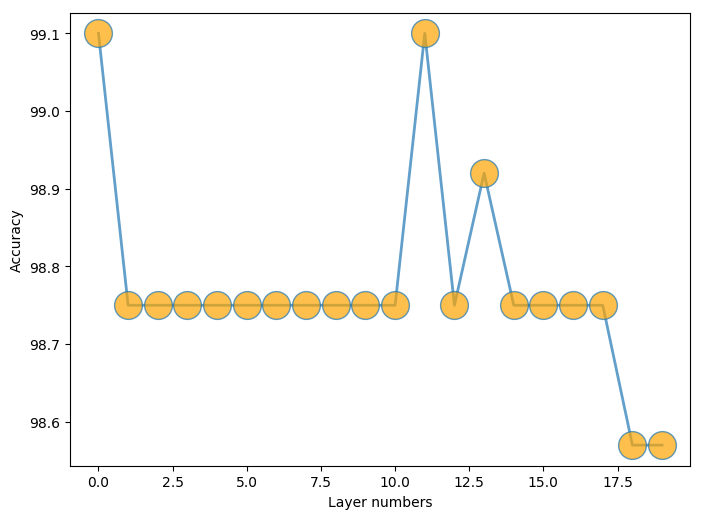

In [16]:
print ("Opt_layer_num =",Accuracy.index(max(Accuracy)), " Accuracy =", max(Accuracy) ,
       "Time =" , np.sum(t[0:Accuracy.index(max(Accuracy))+1]))

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=100)
plt.plot(Accuracy, '-o', ms=20, lw=2, alpha=0.7, mfc='orange')
plt.ylabel('Accuracy')
plt.xlabel('Layer numbers')
plt.show()

In [17]:
Accuracy

[99.1,
 98.75,
 98.75,
 98.75,
 98.75,
 98.75,
 98.75,
 98.75,
 98.75,
 98.75,
 98.75,
 99.1,
 98.75,
 98.92,
 98.75,
 98.75,
 98.75,
 98.75,
 98.57,
 98.57]